## Calculo del delay del retardador a partir de la fuente de iluminacion medida

**Autor**: Jesús del Hoyo

**Fecha**:   01/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

Voy a suponer que al aplicar un polarizador a la salida del diodo, tengo luz linealmente polarizada. Puesto que intenté optimizar la circularidad de la salida de la iluminación rotando la lámina de cuarto de onda, debo estar en la situación mejor circularmente polarizada posible. Debo encontrar el delay que genera dicha iluminación.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D, plot_2d, clean_intensity
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import numpy as np
import os

## Cargar datos

** Datos experimentales **

In [4]:
intensity_0 = np.array([-0.0243, 0.0217])
# Load file, Illumination maximum
filename = 'Intensidad_max_2018-10-01.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
mean = np.mean(Iindividual, axis=0)
print(mean)

[5.9535574 4.2471744]


Text(0.5,1,'Senal')

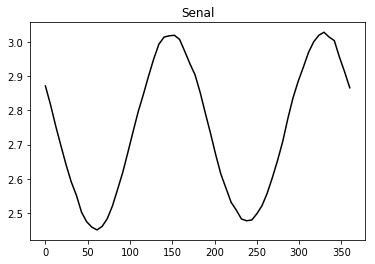

In [20]:
# Experiment of circularity
IexpCirc = [2.8309, 4.1868, 2.7797, 4.1919, 2.7183, 4.1919, 2.6620, 4.1919, 2.6006, 4.1817, 2.5545, 4.1868, 2.5187, 4.1919, 2.4727, 4.1971, 2.4420, 4.1919, 2.4266, 4.1919, 2.4215, 4.1971, 2.4317, 4.1971, 2.4573, 4.2022, 2.4880, 4.1919, 2.5392, 4.1971, 2.5852, 4.1919, 2.6466, 4.1971, 2.7029, 4.1919, 2.7643, 4.1971, 2.8104, 4.1919, 2.8667, 4.1971, 2.9127, 4.1919, 2.9588, 4.1971, 2.9792, 4.1971, 2.9792, 4.1919, 2.9844, 4.1971, 2.9690, 4.1919, 2.9383, 4.1971, 2.9025, 4.1971, 2.8667, 4.1919, 2.8155, 4.1919, 2.7592, 4.1971, 2.6978, 4.1919, 2.6364, 4.1919, 2.5801, 4.1919, 2.5392, 4.1919, 2.4983, 4.1919, 2.4727, 4.1868, 2.4471, 4.1868, 2.4420, 4.1868, 2.4471, 4.1919, 2.4624, 4.1868, 2.4829, 4.1817, 2.5187, 4.1817, 2.5699, 4.1919, 2.6159, 4.1868, 2.6773, 4.1971, 2.7439, 4.1971, 2.8002, 4.1919, 2.8513, 4.1971, 2.8923, 4.1971, 2.9383, 4.2022, 2.9690, 4.2022, 2.9844, 4.1971, 2.9895, 4.1919, 2.9792, 4.1971, 2.9690, 4.1971, 2.9281, 4.2073, 2.8820, 4.2022, 2.8360, 4.2022]
num_data = 60
angle1 = sp.linspace(0,360,num_data)*degrees
# Separate channels
Icirc = np.zeros([num_data, 2])
for ind, I in enumerate(IexpCirc):
    if ind%2 == 0:
        Icirc[ind/2,0] = I
    else:
        Icirc[ind/2,1] = I
# Correct values
Icirc = clean_intensity(Icirc, mean[1], Nd=1)
# Print them
plt.figure()
plt.plot(angle1/degrees, Icirc,'k')
plt.title('Senal')

** Datos teóricos**

In [9]:
# Already characterized elements
(p11,p12, delay1) = (0.962421338047, 0.0723017114037, 109.674226344*degrees)
(p21, p22) = (0.974429083571, 0.0933985896782)
th0p1 = (122.449494104 + 125.992)*degrees #
th0p2 = (104.736748578 + 135.633)*degrees # + 135.633
th0p1ad = 4.49058478366*degrees
parR1 = [1.00633931598, 1.01339903131, 84.6008729373*degrees]
th0r1 = 175.571888512*degrees
th0r1ad = 9.1554487636*degrees
parR2 = [0.932112996884, 0.936748373013, 81.6800679199*degrees]
th0r2 = 2.78054116251*degrees
Jp1 = ps.Mueller_Real_Retarder(p11, p12, delay1)
Jp2 = ps.polarizer_linear(p21, p22)
Jr1 = ps.Mueller_Real_Retarder(parR1[0], parR1[1], parR1[2])
Jr2 = ps.Mueller_Real_Retarder(parR2[0], parR2[1], parR2[2])
M = [Jp1, Jr1, Jr2, Jp2]
th0 = [th0p1+th0p1ad, th0r1+th0r1ad, th0r2, th0p2]
Ifuente = np.matrix(np.array([[5.86922518], [0.56906085], [-0.25053408], [5.83619796]]))

## Calcular el delay del retardador

The mean square error is: 0.0023345964345.
Fit parameters: I0 = 5.72493785573; Th0R = 42.7315061587º; Th0P = 86.1596500354º; Delay = 82.0º


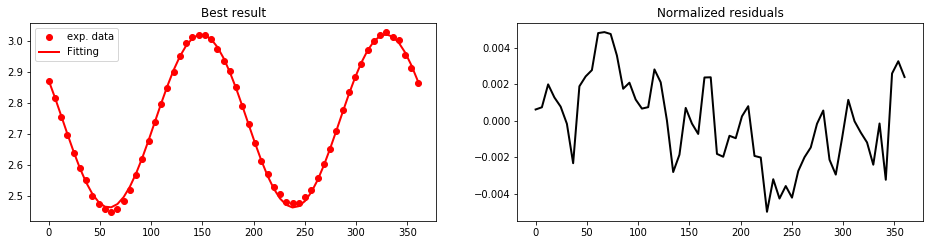

In [24]:
# Parametros iniciales
par0 = [5.87, 0*degrees, 0*degrees, 82*degrees]
# Definir funciones
def model_func1D(par, th1): 
    # Illumination
    Ifuente = np.matrix(np.array([[par[0]], [par[0]], [0], [0]]))
    # Create Jones matrices
    Jr0 = ps.Mueller_Real_Retarder(1, 1, par[2])
    J = [Jr0, Jp2]
    th = [par[1], th1-par[2]]
    Iteor = Intensity_Rotating_Elements(J, th, Ei = Ifuente)
    return Iteor
def err_func1D(par, th1, Ireal, verbose=False): 
    Iteor = model_func1D(par, th1)
    diferencia = Iteor - Ireal
    if verbose:
        error = np.std(diferencia)/Ireal.max()
        print('The mean square error is: {}.'.format(error))
    return diferencia
# Start optimization
par1, success = optimize.leastsq(err_func1D, par0, args=(angle1, Icirc))
#par1, success = optimize.leastsq(err_func1D, par0, args=(angle_e1a, angle_e1b, angle_e1c, I_e1a_double[:,0], I_e1b_double[:,0], I_e1c_double[:,0]))
_ = err_func1D(par1, angle1, Icirc, verbose=True)
# Print parameters
print('Fit parameters: I0 = {}; Th0R = {}º; Th0P = {}º; Delay = {}º'.format(
    par1[0], (par1[1]/degrees)%180, (par1[2]/degrees)%180, (par1[3]/degrees)%180 ))
# Print results
I_fit = model_func1D(par1, angle1)
plot_experiment_residuals_1D(angle1, Icirc, I_fit,  title='Best result')

## Conclusion

The delay of the retarder is 82º.

In [29]:
# Delay from specifications
print(31*90/pi)

888.084582453
